In [1]:
import fatf
import numpy as np
import fatf.utils.data.datasets as fatf_datasets
import fatf.utils.models.models as fatf_models
import sklearn.metrics
import matplotlib.pyplot as plt
import fatf.utils.data.discretisation as fatf_discretisation
import sklearn
import sklearn.ensemble

21-Jun-30 14:30:54 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [2]:
# hence it does the “reverse sampling”, which introduces randomness to the explainer

In [3]:
fatf.setup_random_seed(42)

21-Jun-30 14:31:00 fatf         INFO     Seeding RNGs using the input parameter.
21-Jun-30 14:31:00 fatf         INFO     Seeding RNGs with 42.


In [4]:
iris_data_dict = fatf_datasets.load_iris()
iris_data = iris_data_dict['data']
iris_target = iris_data_dict['target']
iris_feature_names = iris_data_dict['feature_names'].tolist()
iris_target_names = iris_data_dict['target_names'].tolist()

In [5]:
blackbox_model = sklearn.ensemble.RandomForestClassifier(n_estimators=10)
blackbox_model.fit(iris_data, iris_target)

RandomForestClassifier(n_estimators=10)

In [6]:
predictions = blackbox_model.predict(iris_data)
sklearn.metrics.accuracy_score(iris_target, predictions)

1.0

In [7]:
data_point = iris_data[0]
data_point

array([5.1, 3.5, 1.4, 0.2], dtype=float32)

In [8]:
data_point_probabilities = blackbox_model.predict_proba(
data_point.reshape(1, -1))[0]
data_point

array([5.1, 3.5, 1.4, 0.2], dtype=float32)

In [9]:
data_point_probabilities

array([1., 0., 0.])

In [10]:
data_point_prediction = data_point_probabilities.argmax(axis=0)
data_point_prediction

0

In [11]:
data_point_class = iris_target_names[data_point_prediction]
data_point_class

'setosa'

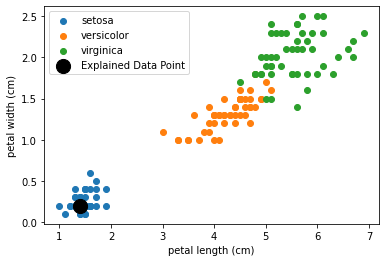

In [12]:
>>> iris_feature_names[2:]
['petal length (cm)', 'petal width (cm)']

_ = plt.figure()
_ = plt.scatter(
    iris_data[1:50, 2],
    iris_data[1:50, 3],
    label=iris_target_names[0])
_ = plt.scatter(
    iris_data[50:100, 2],
    iris_data[50:100, 3],
    label=iris_target_names[1])
_ = plt.scatter(
    iris_data[100:150, 2],
    iris_data[100:150, 3],
    label=iris_target_names[2])
_ = plt.scatter(
    data_point[2],
    data_point[3],
label='Explained Data Point',
   s=200, c='k')

_ = plt.xlabel(iris_feature_names[2])
_ = plt.ylabel(iris_feature_names[3])
_ = plt.legend()

In [13]:
# quartile discretiser
discretiser = fatf_discretisation.QuartileDiscretiser(iris_data,feature_names=iris_feature_names)

In [14]:
import fatf.utils.data.augmentation as fatf_augmentation
augmenter = fatf_augmentation.Mixup(iris_data, ground_truth=iris_target)

In [15]:
# # ridge regression for explanation generation
import sklearn.linear_model
lime = sklearn.linear_model.Ridge()

In [16]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Data Augmentation ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

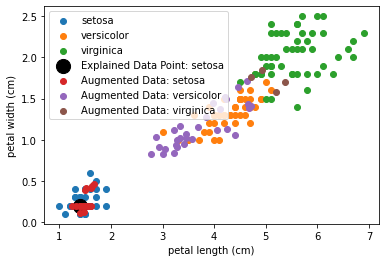

In [17]:
sampled_data = augmenter.sample(data_point, samples_number=50)
sampled_data_probabilities = blackbox_model.predict_proba(sampled_data)
sampled_data_predictions = sampled_data_probabilities.argmax(axis=1)
sampled_data_0_indices = np.where(sampled_data_predictions == 0)[0]
sampled_data_1_indices = np.where(sampled_data_predictions == 1)[0]
sampled_data_2_indices = np.where(sampled_data_predictions == 2)
_ = plt.figure()
_ = plt.scatter(
    iris_data[1:50, 2],
    iris_data[1:50, 3],
    label=iris_target_names[0])
_ = plt.scatter(    iris_data[50:100, 2],
    iris_data[50:100, 3],
    label=iris_target_names[1])
_ = plt.scatter(
    iris_data[100:150, 2],
    iris_data[100:150, 3],
    label=iris_target_names[2])
_ = plt.scatter(
    data_point[2],
    data_point[3],
    label='Explained Data Point: {}'.format(data_point_class),
    s=200,
    c='k')
_ = plt.scatter(
    sampled_data[sampled_data_0_indices, 2],
    sampled_data[sampled_data_0_indices, 3],
    label='Augmented Data: {}'.format(iris_target_names[0]))
_ = plt.scatter(
    sampled_data[sampled_data_1_indices, 2],
    sampled_data[sampled_data_1_indices, 3],
    label='Augmented Data: {}'.format(iris_target_names[1]))
_ = plt.scatter(
    sampled_data[sampled_data_2_indices, 2],
    sampled_data[sampled_data_2_indices, 3],
    label='Augmented Data: {}'.format(iris_target_names[2]))
_ = plt.xlabel(iris_feature_names[2])
_ = plt.ylabel(iris_feature_names[3])
_ = plt.legend()

In [18]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Interpretable Representation ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [19]:
import fatf.utils.data.transformation as fatf_transformation
data_point_discretised = discretiser.discretise(data_point) # all data
sampled_data_discretised = discretiser.discretise(sampled_data) # Sample data

# from the 4*4 to the binary interpretable reprecentation.
sampled_data_binarised = fatf_transformation.dataset_row_masking(
sampled_data_discretised, data_point_discretised)

In [37]:
sampled_data_binarised[0, :]

array([0, 1, 1, 1], dtype=int8)

In [21]:
import fatf.utils.distances as fatf_distances
import fatf.utils.kernels as fatf_kernels
features_number = sampled_data_binarised.shape[1]
kernel_width = np.sqrt(features_number) * 0.75  # LIME Karnel constat (something proportional to the sqrt of n_features)

distances = fatf_distances.euclidean_point_distance(
    np.ones(features_number), sampled_data_binarised)
weights = fatf_kernels.exponential_kernel(
    distances, width=kernel_width) # Exponential kernal

In [22]:
fatf_transformation.dataset_row_masking(
    data_point_discretised.reshape(1, -1), data_point_discretised)

array([[1, 1, 1, 1]], dtype=int8)

In [23]:
iris_target_names.index('setosa')

0

In [24]:
sampled_data_predictions_setosa = sampled_data_probabilities[:, 0]

In [25]:
import fatf.utils.data.feature_selection.sklearn as fatf_feature_ssk

lasso_indices = fatf_feature_ssk.lasso_path(
    sampled_data_binarised, sampled_data_predictions_setosa, weights, 2) # feature selection selects the top 2 (out of 4)

In [26]:
sampled_data_binarised_2f = sampled_data_binarised[:, lasso_indices]

In [27]:
interpretable_feature_names = []
for feature_index in lasso_indices:
    bin_id = data_point_discretised[feature_index].astype(int)
    interpretable_feature_name = (
        discretiser.feature_value_names[feature_index][bin_id])
    interpretable_feature_names.append(interpretable_feature_name)
    interpretable_feature_names

In [28]:
lime.fit(
     sampled_data_binarised_2f,
     sampled_data_predictions_setosa,
     sample_weight=weights)


Ridge()

In [29]:
for name, importance in zip(interpretable_feature_names, lime.coef_):
     print('->{}<-: {}'.format(name, importance))

->*sepal length (cm)* <= 5.10<-: 0.2819720103666909
->*petal length (cm)* <= 1.60<-: 0.6075655408137073


In [30]:
# Surrogate Tree

In [31]:
features_number = sampled_data.shape[1]
kernel_width = np.sqrt(features_number) * 0.75

distances = fatf_distances.euclidean_point_distance(
    data_point, sampled_data)
weights = fatf_kernels.exponential_kernel(
    distances, width=kernel_width)

In [32]:
import sklearn.tree

blimey_tree = sklearn.tree.DecisionTreeClassifier(max_depth=3) # 3 is  the Parameter ... the smaller the more interpretable
blimey_tree.fit(
    sampled_data, sampled_data_predictions, sample_weight=weights)

DecisionTreeClassifier(max_depth=3)

In [33]:
for n_i in zip(iris_feature_names, blimey_tree.feature_importances_):
     name, importance = n_i
     print('->{}<-: {}'.format(name, importance))

->sepal length (cm)<-: 0.0
->sepal width (cm)<-: 0.0
->petal length (cm)<-: 1.0
->petal width (cm)<-: 0.0


In [34]:
blimey_tree_text = sklearn.tree.export_text(
    blimey_tree, feature_names=iris_feature_names)
print(blimey_tree_text)

|--- petal length (cm) <= 2.22
|   |--- class: 0
|--- petal length (cm) >  2.22
|   |--- petal length (cm) <= 4.72
|   |   |--- class: 1
|   |--- petal length (cm) >  4.72
|   |   |--- class: 2



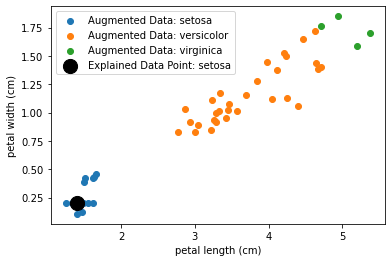

In [35]:
_ = plt.figure()
_ = plt.scatter(
    sampled_data[sampled_data_0_indices, 2],
    sampled_data[sampled_data_0_indices, 3],
    label='Augmented Data: {}'.format(iris_target_names[0]))
_ = plt.scatter(
    sampled_data[sampled_data_1_indices, 2],
    sampled_data[sampled_data_1_indices, 3],
    label='Augmented Data: {}'.format(iris_target_names[1]))
_ = plt.scatter(
    sampled_data[sampled_data_2_indices, 2],
    sampled_data[sampled_data_2_indices, 3],
    label='Augmented Data: {}'.format(iris_target_names[2]))
_ = plt.scatter(
    data_point[2],
    data_point[3],
    label='Explained Data Point: {}'.format(data_point_class),
    s=200,
    c='k')

_ = plt.xlabel(iris_feature_names[2])
_ = plt.ylabel(iris_feature_names[3])
_ = plt.legend()